Ziv Shahar - 204418917

Yoel Bokobza - 312190481

Oded George - 319066890


In [1]:
%load_ext tensorboard
from datetime import datetime
from packaging import version
from IPython.display import Image

# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorboard.plugins import projector
from tensorflow.keras import regularizers
from collections import Counter
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import seaborn as sns
import pandas as pd
import seaborn as sns
import functools
import pickle 
import tqdm
import cv2

tf.random.set_seed(0)
np.random.seed(0) # To reproduce experiment

#1.1 Vanilla Training
# Basic classification: Classify images of clothing

## Import the Fashion MNIST dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Originally, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images (test).
We further split the train set into train and validation, such that 50000 images were used for training and 10000 for validation.

If we will use the test set to examing our model (without validation set), we may encounter overfitting phenomena over the test data, which in turn will lead to good preformance over the test set, this phenomena may occur becuase we are tuning our model to achieve good preformance over a specific set of test samples. 
This is a problem because the main reason that we are using a test set is to evaluate our model preformance over an unseen data,
i.e., we test how well the training procedure will be able to generalize for unseen samples. 
We can avoid this issue by examing our model preformance (during the bulding procedure) via another set which we call "validation" set. The validation dataset is different from the test dataset, 
both datasets are held back from the training of the model,but the validation set used to give an unbiased preformance estimation
of the final tuned model when comparing between different final models.

You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#Split the train set into training and validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images,
                                                    train_labels,
                                                    test_size=1/6,
                                                    random_state=42) 

4431872/4422102 [==============================] - 0s 0us/step


We created 6 NumPy arrays from the dataset:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The `val_images` and `val_labels` arrays are the *validation set*—the data the model uses to validate its performance during training.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9.

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def confusion_matrix_plot(labels, predicted_labels, class_names):
    """
    This function creates and plot the confusion matrix.
    A confusion matrix is a technique for summarizing the performance of a classification algorithm
    """
    result = tf.math.confusion_matrix(labels, predicted_labels)
    ax = sns.heatmap(result, annot=True, cmap='Blues', fmt='1d')
    ax.set_title('Confusion metrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Ground truth ');
    ax.xaxis.set_ticklabels(class_names, rotation=45)
    ax.yaxis.set_ticklabels(class_names, rotation=45)
    plt.show()

In [ ]:
def accuracy_per_class_plot(test_images_new, label_list, class_names, model ):
    """
    This function calculates the accuracy per class and plot it as bar plot
    """
    test_loss = [ 0 for i in range(len(class_names))]
    test_acc = [ 0 for i in range(len(class_names))]
    for label in range(len(class_names)):
        test_loss[label], test_acc[label] = model.evaluate(test_images_new[label],  label_list[label], verbose=0)
        print(f'Test accuracy for class number {label} is:\n', test_acc[label])
        
    plt.figure(figsize=(8, 8), dpi=80)
    plt.title("Accuracy per class idx")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.bar(class_names , test_acc)
    plt.show() 

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 50,000 images in the training set, with each image represented as 28 x 28 pixels:

In [ ]:
train_images.shape
len(train_labels)

50000

Likewise, there are 50,000 labels in the training set:

In [ ]:
len(train_labels)

50000

Each label is an integer between 0 and 9:

In [ ]:
train_labels

array([5, 0, 0, ..., 6, 6, 1], dtype=uint8)

*There* are 10,000 images in the validation set (28X28 pixels)

In [ ]:
val_images.shape

(10000, 28, 28)

There are also 10000 images labels for the validation set

In [ ]:
len(val_labels)

10000

*There* are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [ ]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [ ]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

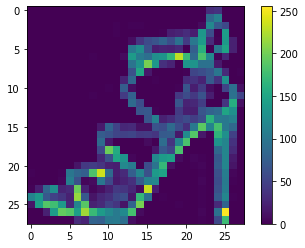

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set*, the *validation set*, and the *testing set* be preprocessed in the same way:

In [ ]:
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

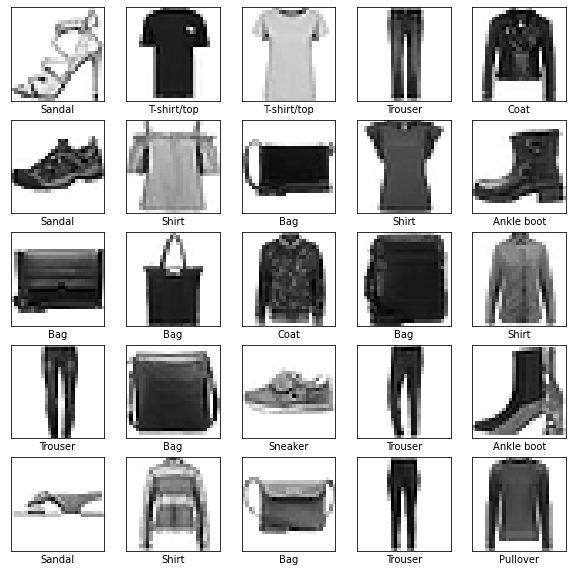

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [ ]:
embedding = tf.keras.layers.Dense(128, activation='relu')
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    embedding,
    tf.keras.layers.Dense(10)
])

Model Architecture Visualisation


The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [ ]:
#Defining logs path for tensorboard
log_dir = "logs/fit/VanillaTraining/" + datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.fit(train_images, train_labels,
          validation_data=(val_images, val_labels), 
          batch_size=32,
          epochs=10,
          callbacks=[tensorboard_callback])

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 0.5112 - accuracy: 0.8204 - val_loss: 0.4089 - val_accuracy: 0.8519
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.3817 - accuracy: 0.8622 - val_loss: 0.3884 - val_accuracy: 0.8599
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.3431 - accuracy: 0.8741 - val_loss: 0.3637 - val_accuracy: 0.8697
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3171 - accuracy: 0.8832 - val_loss: 0.3718 - val_accuracy: 0.8692
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2981 - accuracy: 0.8903 - val_loss: 0.3363 - val_accuracy: 0.8776
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2834 - accuracy: 0.8959 - val_loss: 0.3458 - val_accuracy: 0.8765
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2679 - accuracy: 0.8999 - val_loss: 0.3606 - val_accur

### Tensor Board

Acuuracy VS Epoch and Loss VS Epoch for both training and validation sets with baseline model

In [ ]:
%tensorboard --logdir logs/fit/VanillaTraining

As we can see, there is overfitting, as the training loss decreases much faster than the validation loss, and it seems that the validation loss saturates.

## TSNE

The method of t-distributed Stochastic Neighbor Embedding (t-SNE) is a method for dimensionality reduction, used mainly for the visualization of data in 2D and 3D maps. This method can find non-linear connections in the data and therefore it is highly popular.

### The Algorithm

The first stage of the algorithm is calculating the Euclidian distances of each point from all of the other points. Then, take these distances and transform them into conditional probabilities that represent the similarity between every two points. It means that we want to evaluate how similar every two points in the data are, or in other words, how likely they are to be neighbors. After that, we create a dataset of points in a low-dimensional space and calculate a joint probability distribution for them as well (to do that, we build a random dataset of points with the same number of points as we had in the original dataset). Then, we use the Kullback-Leiber divergence to make the joint probability distribution of the data points in the low dimension as similar as possible to the one from the original dataset. If this transformation succeeds we will get a good dimension reduction. KL divergence is a measure of how much two distributions are different from one another.
Note that unlike PCA the TSNE is an iterative method (using gradient descent). Its goal is to change the lower dimension dataset such that its joint probability distribution will be as similar as possible to the original data. The cost function that the gradient descent tries to minimize is the KL divergence of the joint probability distribution P from the high dimensional space and Q from the low dimensional space.



In [ ]:
def generate_tsne(model, data, labels, LOG_DIR):

  # creating a new model by removing the last layer
  cust_model = tf.keras.models.Sequential()
  for layer in model.layers[:-1]:
    cust_model.add(layer)

  features_vec = cust_model.predict(data)
  pickle.dump(features_vec, open('features_vectors_fashion_mnist.pkl', 'wb'))

  # creating metadata file that contain the corresponding label
  # for each image in the dataset
  if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

  metadata_file = open(os.path.join('/content', LOG_DIR, 'metadata_10_classes_fashion_mnist.tsv'), 'w', encoding='utf-8')
  metadata_file.write('Class\tName\n')

  for idx in labels:
    label = idx
    name = class_names[idx]
    metadata_file.write('{}\t{}\n'.format(label, name))
  metadata_file.close()

  # set the config and visualize
  with open('features_vectors_fashion_mnist.pkl', 'rb') as f:
    features_vectors = pickle.load(f)
  features = tf.Variable(features_vectors, name='features')
  checkpoint = tf.train.Checkpoint(embedding=features)
  checkpoint.save(os.path.join(LOG_DIR, "embedding.ckpt"))
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()
  embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
  embedding.metadata_path = os.path.join('/content', LOG_DIR, 'metadata_10_classes_fashion_mnist.tsv')
  projector.visualize_embeddings(LOG_DIR, config)


In [ ]:
generate_tsne(model, train_images, train_labels, 'embedding_logs_train')

TSNE visualization for train images in baseline model

In [ ]:
%tensorboard --logdir=embedding_logs_train 

We can see that the spatial dimension representation of images per different class is almost seperated which is a sign that the model can distinguish between different classes.

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

### Total Test accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.885200023651123


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data.

### Accuracy per Class

In [ ]:
def class_splitter(test_images, test_labels, classes=10):
    """
    This function creates  a list of images per class
    """
    test_images_new = [[] for _ in range(classes)]
    label_list = [ [] for _ in range(classes)]
    for idx, label in enumerate(test_labels):
          test_images_new[label].append(test_images[idx]) 
    for label in range(classes):
        label_list[label] =  [label for i in range(len(test_images_new[label]))]
    test_images_new = [np.array(i) for i in test_images_new]
    label_list = [np.array(i) for i in label_list]
    return np.array(test_images_new), np.array(label_list)

In [ ]:
test_images_list, label_list = class_splitter(test_images,  test_labels)

Test accuracy for class number 0 is:
 0.8299999833106995
Test accuracy for class number 1 is:
 0.9760000109672546
Test accuracy for class number 2 is:
 0.8240000009536743
Test accuracy for class number 3 is:
 0.9160000085830688
Test accuracy for class number 4 is:
 0.8130000233650208
Test accuracy for class number 5 is:
 0.9549999833106995
Test accuracy for class number 6 is:
 0.6449999809265137
Test accuracy for class number 7 is:
 0.9559999704360962
Test accuracy for class number 8 is:
 0.9670000076293945
Test accuracy for class number 9 is:
 0.9700000286102295


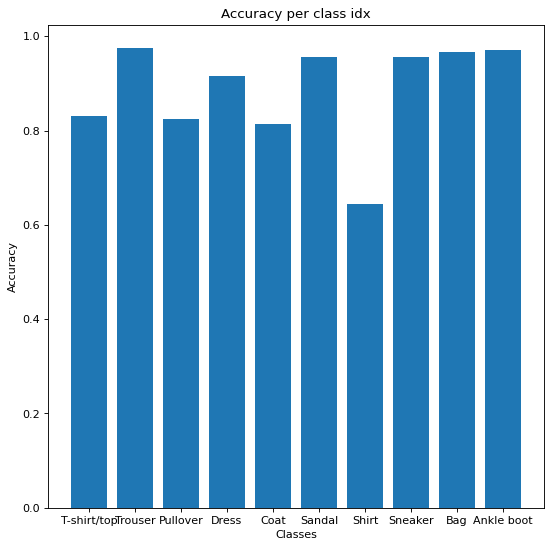

In [ ]:
accuracy_per_class_plot(test_images_list, label_list, class_names, model )

From the histogram above, one may infer that there are classes which are harder for the model to predict. This can be because images belonging to some classes are more diverse, or that it is harder to extract features from these images.

### Confusion Matrix

In [ ]:
predicted_labels = tf.argmax(tf.nn.softmax(model.predict(test_images)), axis=1)

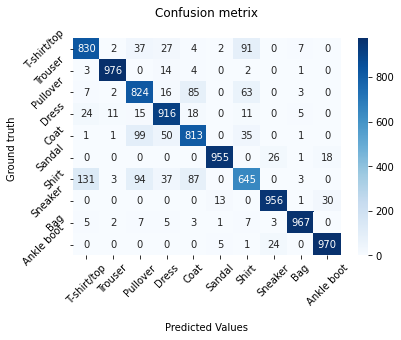

In [ ]:
confusion_matrix_plot(test_labels, predicted_labels, class_names)

It can be observed that the model tends to confuse between T-shirt and Shirt, pullover and coat. This is make sense because they are looks alike.

#### T-SNE test set
Now let's see how much the clusters are separated in our test set domain by dimensionality reduction TSNE

In [ ]:
generate_tsne(model, test_images, test_labels, 'embedding_logs_test')

TSNE visualization for test images in baseline model

In [ ]:
%tensorboard --logdir=embedding_logs_test 
#If you cant see the visualization, click the refresh button

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([4.6264876e-07, 7.3752680e-09, 2.2685350e-07, 3.1692451e-09,
       8.4404668e-08, 6.7195101e-03, 2.9897183e-07, 2.7163168e-03,
       1.3343110e-06, 9.9056178e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [ ]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

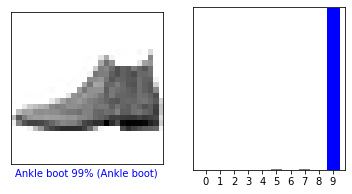

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

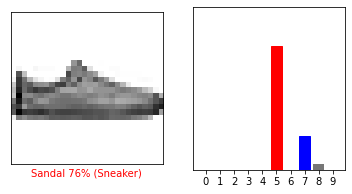

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

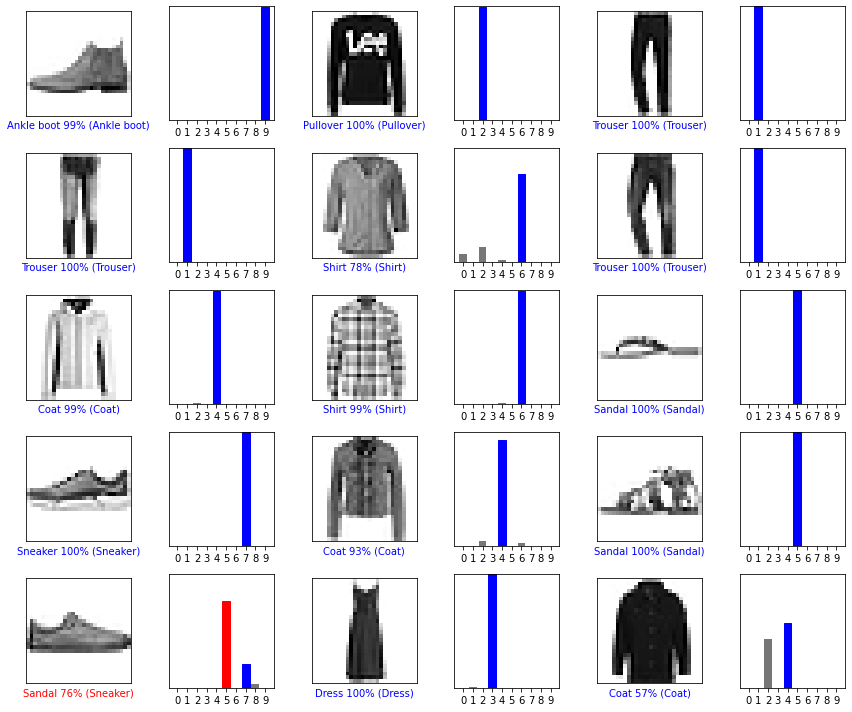

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# 1.2 Dataset Manipulation
In this section we will explore the new parition of the data.
We will change the labels of the images to match the following labels:

(1) **Top**: [T-Shirt/Top, Pullover, Dress, Coat, Shirt]

(2) **Bottom**: [Trouser, Sandal, Sneaker, Ankle Boot]

(3) **Accessories**: [Bag]

Lets reorganize the classes:

In [ ]:
def reorganize_classes(labels):
    """
    This function, creates 3 classes from the 10 classes.
    """
    new_labels = np.copy(labels)
    for idx, label in enumerate(labels) :
        ## TOP = 0
        if label == 0 or label == 2 or label == 3 or label == 4 or label == 6:
            new_labels[idx] = 0.0
        ## Bottom = 1
        elif label == 1 or label == 5 or label == 7 or label == 9 :
            new_labels[idx] = 1.0
        ## Accessories = 2
        elif label == 8 :
            new_labels[idx] = 2.0        
    return  new_labels

In [ ]:
class_names_after_manip = ["Top","Bottom","Accessories"]
train_labels_after_manip = reorganize_classes(train_labels)
val_labels_after_manip = reorganize_classes(val_labels)
test_labels_after_manip = reorganize_classes(test_labels)

In [ ]:
counts_new = Counter(train_labels_after_manip) #Count the number of labels per class in the new classes formation (3 classes)
counts_old = Counter(train_labels)#Count the number of labels per clsas in the old classes formation (10 classes

## New classes data histogram

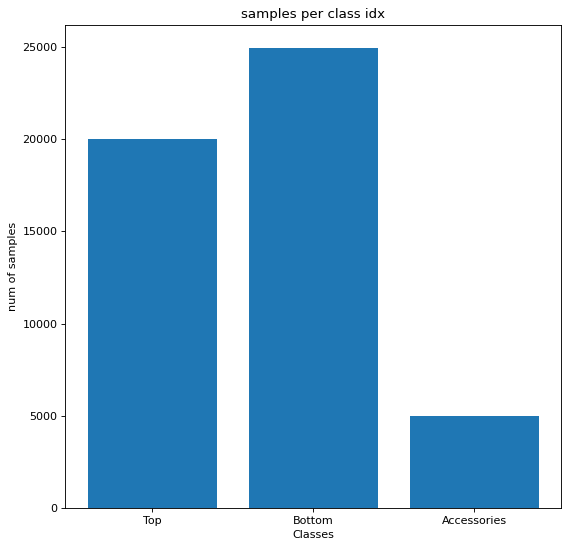

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.title("samples per class idx")
plt.xlabel("Classes")
plt.ylabel("num of samples")
plt.bar(["Top","Bottom","Accessories"], counts_new.values())
plt.show() 

## Original classes data histogram

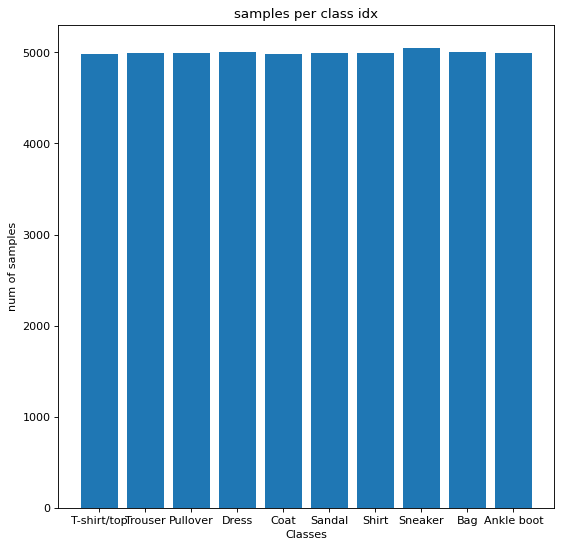

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.title("samples per class idx")
plt.xlabel("Classes")
plt.ylabel("num of samples")
plt.bar(class_names, counts_old.values())
plt.show() 

As we can see from our observations, in our original train dataset the labels were distributed uniformly, in comparison to the new dataset which is imbalanced. It's known that imbalanced data causes problems in the classification tasks.
For instance, consider the case of classifying dogs and cats, and our dataset contains a single sample of cat, in that case, there is a concern that the model will learn to predict dogs regardless of what the input is. furthermore, in this case, the accuracy of the model over the training set will be almost 100% even though the model is poor. In general, we would like the dataset to be balanced.

But, we can expect better accuracy in this model. The reason is that the number of classes is reduced and it might be easier for the model to classify. For example, as we saw earlier in the confusion matrix, the model tends to confuse between T-Shirt/Top, Pullover, Dress, Coat, Shirt. Therefore unifying them into a single class should increase accuracy.

In [ ]:
log_dir = "logs/fit/new_classes/" + datetime.now().strftime("%Y%m%d-%H%M%S") #"drive/MyDrive/logs/fit/DatasetManipulation" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Model training with new classes

In [ ]:
embedding2 = tf.keras.layers.Dense(128, activation='relu')
model_manipulate = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    embedding2,
    tf.keras.layers.Dense(3)
])
model_manipulate.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_manipulate.fit(train_images, train_labels_after_manip,
          validation_data=(val_images, val_labels_after_manip), 
          batch_size=32,
          epochs=10,
          callbacks=[tensorboard_callback])

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0781 - accuracy: 0.9778 - val_loss: 0.0526 - val_accuracy: 0.9851
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0449 - accuracy: 0.9874 - val_loss: 0.0508 - val_accuracy: 0.9852
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0353 - accuracy: 0.9897 - val_loss: 0.0387 - val_accuracy: 0.9891
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0274 - accuracy: 0.9919 - val_loss: 0.0381 - val_accuracy: 0.9896
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0236 - accuracy: 0.9929 - val_loss: 0.0372 - val_accuracy: 0.9893
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.0385 - val_accuracy: 0.9896
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.0372 - val_accuracy:

Acuuracy VS Epoch and Loss VS Epoch for both training and validation sets with modified model

In [ ]:
%tensorboard --logdir logs/fit/new_classes

There is also an overfitting but this time, much more aggressive. The reason is that the task is simplified compared to the original and we used the same model. Therfore, the model capacity is too large for this simple problem.

### Total Test accuracy

In [ ]:
test_loss_after_manip, test_acc_after_manip = model_manipulate.evaluate(test_images,  test_labels_after_manip)
print('Test accuracy:', test_acc_after_manip)

313/313 [==============================] - 1s 2ms/step - loss: 0.0375 - accuracy: 0.9901
Test accuracy: 0.9901000261306763


As we can observe, the results are indeed improved

### Accuracy per Class

In [ ]:
test_images_list_after_manip, label_list_after_manip = class_splitter(test_images,  test_labels_after_manip, classes=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


Test accuracy for class number 0 is:
 0.991599977016449
Test accuracy for class number 1 is:
 0.9912499785423279
Test accuracy for class number 2 is:
 0.9779999852180481


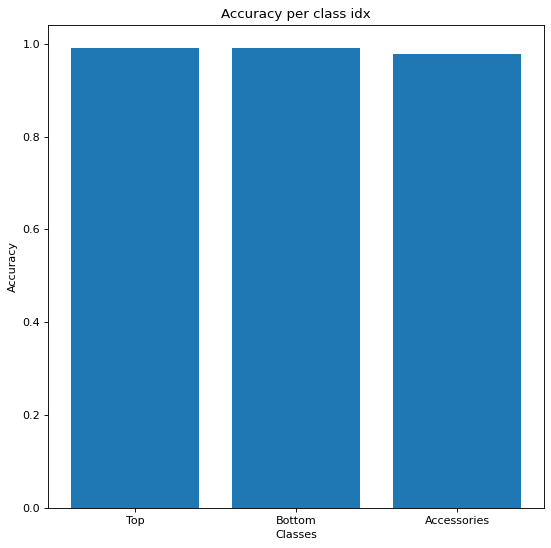

In [ ]:
accuracy_per_class_plot(test_images_list_after_manip, label_list_after_manip, class_names_after_manip, model_manipulate)

When the number of classes increases, the model has to learn more complex features to classify instances correctly, so in our case when the number of classes is small compared to the first model we expect that we will get a better accuracy.

In the histogram above, we can see that the third class has the lowest accuracy compare to the others, and it might be affected by the fact that the data is imbalanced, and the number of accessories samples is small.



## Confusion Matrix

In [ ]:
predicted_labels_after_manip = tf.argmax(tf.nn.softmax(model_manipulate.predict(test_images)), axis=1) #predicting the labels with the model trained over the manipulated data

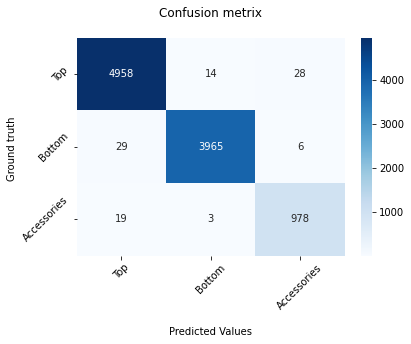

In [ ]:
confusion_matrix_plot(test_labels_after_manip, predicted_labels_after_manip, class_names_after_manip)

TSNE train

In [ ]:
generate_tsne(model_manipulate, train_images, train_labels_after_manip, 'embedding2_logs_train')


TSNE visualization for train images in the modified model

In [ ]:
%tensorboard --logdir=embedding2_logs_train 
#If you cant see the visualization, click the refresh button or rerun this cell

TSNE test

In [ ]:
generate_tsne(model_manipulate, test_images, test_labels_after_manip, 'embedding2_logs_test')


TSNE visualization for test images in modified model

In [ ]:
%tensorboard --logdir=embedding2_logs_test 
#If you cant see the visualization, click the refresh button or rerun this cell

# 1.3 Data Augmentation

In this section you will explore the use of augmentation on your training

Data augmentation can be very helpful if the dataset is small and we want to increases the number of samples. In addition, it allows to enrich the dataset such that the model will be more robust to manipulations such as rotation, cropping, noise, and etc.
We are using data generator that able to apply the following augmentations:


*   Random Crop
*   Random Cutout
*   Adding Noise
*   Random Rotate
*   Random Flip vertically 
*   Random Flip Horizontally







In [ ]:
example_img = np.expand_dims(train_images[0], axis=-1) #Adding dummy dimension
H, W, _ = example_img.shape

In [ ]:
def resize_img(img, H, W):
  res_img = cv2.resize(np.copy(img), dsize=(H, W), interpolation=cv2.INTER_CUBIC)
  return res_img

### Original Image

Text(0.5, 1.0, 'Original Image')

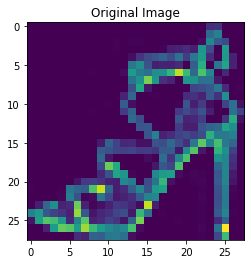

In [ ]:
plt.imshow(example_img.squeeze())
plt.title('Original Image')

### Cropped Image
Unlike scaling, we just randomly sample a section from the original image. We then resize this section to the original image size. This method is popularly known as random cropping.

Text(0.5, 1.0, 'Randomly Cropped Image')

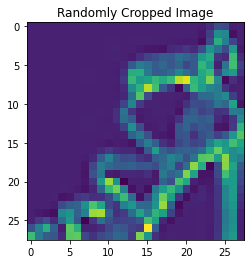

In [ ]:
def random_crop(img, min_size=(25, 25)):
  """
  Cropping an randomly with minimal cropped image size 'min_size', 
  and then resize it to the original size
  """
  H, W, _ = img.shape
  crop_size = (np.random.randint(min_size[1], W), np.random.randint(min_size[0], H))
  w = np.random.randint(0, W-crop_size[0])
  h = np.random.randint(0, H-crop_size[1])
  new_img = img[w:w+crop_size[0],h:h+crop_size[1],:]
  new_img = resize_img(new_img, H, W)
  new_img = np.expand_dims(new_img, axis=-1)
  return new_img

aug_img = random_crop(example_img).squeeze()
plt.imshow(aug_img)
plt.title('Randomly Cropped Image')

### Cutout Image
Randomly (with probability 'prob') masking a small section of the image with random size such that the mask width and height are disributed uniformally between zero to max_size and the mask values are a random number between val_min and val_max.

Text(0.5, 1.0, 'Cutout Image')

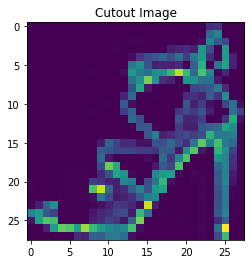

In [ ]:
def cutout(img, max_size=(10, 10), val_min=0, val_max=0.02, prob=0.5):
  """
  Adding mask of maximal size 'max_size' with random size at random postition to
  the image with probability 'prob'.
  The values of the mask are a random number in the range [val_min, val_max]
  """
  H, W, _ = img.shape
  if np.random.rand() > prob:
    return img
  cut_size = (np.random.randint(1, max_size[1]), np.random.randint(1, max_size[0]))
  w = np.random.randint(0, W-cut_size[0])
  h = np.random.randint(0, H-cut_size[1])
  new_img = np.copy(img)
  random_val = np.random.uniform(val_min, val_max)
  new_img[w:w+cut_size[0],h:h+cut_size[1],:] = random_val
  return new_img

aug_img = cutout(example_img, prob=1, val_max=0.02).squeeze()
plt.imshow(aug_img)
plt.title('Cutout Image')

### Gaussian noise
Adding Gaussian noise to image can help the model too be more robust to noise in the input. In addition, because the noise is added randomly in an online fashion during training, it may help the model to avoid overfitting, and generalize better.

Text(0.5, 1.0, 'Noisy Image')

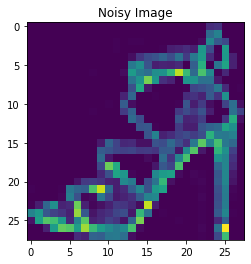

In [ ]:
def add_noise(img, std=0.01):
  """
  Adding a gaussian noise per pixel to an image (gaussian with zero mean and 
  standard deviation 'std')
  """
  return np.copy(img) + np.random.normal(0, std**2, size=(28, 28, 1))

plt.imshow(add_noise(example_img, std=0.01).squeeze())
plt.title('Noisy Image')

### Rotated Image - **Note that this function used for visualization only. We are applying this transformation directly in ImageDataGenerator**

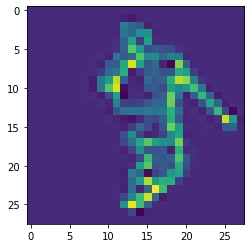

In [ ]:
def rot_img(img, angle=45):
  """
  rotating image by angle
  """
  rot_img = ndimage.rotate(np.copy(img), angle)
  return resize_img(rot_img, H, W)
plt.imshow(rot_img(example_img, angle=45).squeeze())

### Horizontal Flipped Image - **Note that this function used for visualization only. We are applying this transformation directly in ImageDataGenerator**

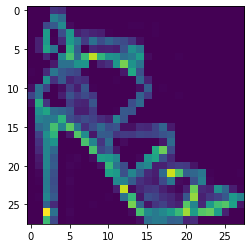

In [ ]:
def horizontal_flip_img(img):
  """
  Horizontally flipping image
  """
  return np.flip(np.copy(img), axis=1)
plt.imshow(horizontal_flip_img(example_img).squeeze())

### Vertically Flipped Image - **Note that this function used for visualization only. We are applying this transformation directly in ImageDataGenerator**

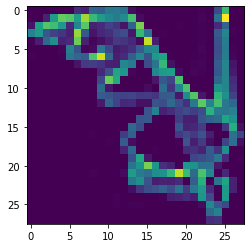

In [ ]:
def vertical_flip_img(img):
  """
  vertically flipping image
  """
  return np.flip(np.copy(img), axis=0)
plt.imshow(vertical_flip_img(example_img).squeeze())

Creating augmented datasets

In [ ]:
def our_preproccess_function(img, transforms): #  This function is fed into the ImageDataGenerator to further add hand-crafted augmentations
  aug_img = img
  for transform in transforms:
    aug_img = transform(aug_img)
  return aug_img

In [ ]:
expanded_dims_train_images = np.array([np.expand_dims(img, axis=-1) for img in train_images]) #Data generator requires 4 dimension data (with external dummy dimension)
expanded_dims_train_images.shape

(50000, 28, 28, 1)

In [ ]:
transforms = [cutout, random_crop, add_noise] # A list of pre-process transforms - 'random_crop', 'cutout', 'add_noise'

In [ ]:
preproccess_function = functools.partial(our_preproccess_function, transforms=transforms)

datagen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preproccess_function 
    )

datagen.fit(expanded_dims_train_images)

## Sampling image from "ImageDataGenerator" after applying all transformation

Text(0.5, 1.0, 'Augmented Image')

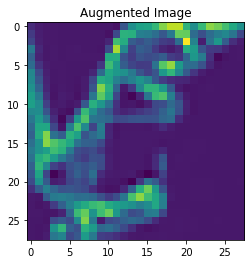

In [ ]:
gen = datagen.flow(expanded_dims_train_images[0:1], batch_size=1)
plt.imshow(gen.next().squeeze())
plt.title("Augmented Image")

# 1.4 Choosing a Model

In this section we will examine the performance of different models with differrent augmentations.

Our new models are CNN based.
The convolution layer in CNN applying a convolution(correlation) operation between a kernel and the image. The motivation behind using this layer in image tasks is that images typically exhibit the following properties:
*   **Stationarity**: Certain motifs often repeat throughout natural signals. In images, this means
that we can expect similar visual patterns to repeat across the image.
*   **Locality**: Nearby points are more correlated than points far away. For instance, if a given pixel is blue, the probability that the adjacent pixels are also blue is pretty high, while the pixels on the opposite end of the image are likely to be independent.

These properties motivates the using of kernel convolution to reduce the number of weights compared to a standard dense layer.

We are also used **Dropout** which is a method used to reduce overfitting by randomly dropping neurons during training. We also used **Batch Normalization** layer which is attempts to enforce the inputs to each layer to have zero mean and unit variance, by normalizing the layer inputs based on the empirical mean and standard deviation computed over the batch forwarded through the network in a given iteration.

We also examined L1, and L2 regularization methods:

**L1 regularization** adds an L1 penalty that is equal to the absolute value of the magnitude of coefficient, or simply restricting the size of coefficients. This regularization method tends to create sparse weight representation.

**L2 Regularization** adds an L2 penalty which is equal to the square of the magnitude of coefficients. For example, Ridge regression and SVM implement this method.

### Padding Convolutions

Adding padding to the convolutional operation can often result in better model performance, as more of the input image of feature maps are given an opportunity to participate or contribute to the output

By default, the convolutional operation uses ‘valid‘ padding, which means that convolutions are only applied where possible.*italicized text* This can be changed to ‘same‘ padding so that zero values are added around the input such that the output has the same size as the input.

## The Models

In [ ]:
#Base line model
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

#conv2D model
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(84, activation=tf.nn.relu),
    tf.keras.layers.Dense(10)    
])

#Adding BN
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(84, activation=tf.nn.relu),
    tf.keras.layers.Dense(10)
])


#Adding DropOut 
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(84, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

#Adding weight decay L2
model5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L2(1e-4), input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.L2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(84, activation=tf.nn.relu, kernel_regularizer=regularizers.L2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, kernel_regularizer=regularizers.L2(1e-4))
])

#Adding weight decay L1
model6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L1(1e-4), input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.L1(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.L1(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(84, activation=tf.nn.relu, kernel_regularizer=regularizers.L1(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, kernel_regularizer=regularizers.L1(1e-4))
])

models = [model1, model2, model3, model4, model5, model6]

Reset Models - This is required as we want the model weights and biases to be initialized in every experiment

In [ ]:
def ResetModels(model):
  for l in model.layers:
      if hasattr(l,"kernel_initializer"):
          l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
      if hasattr(l,"bias_initializer"):
          l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
      if hasattr(l,"recurrent_initializer"):
          l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

## Compiling the models and train them

In [ ]:
def TrainModels(models, transforms, batch_size=32, epochs=10, vertical_flip=False, horizontal_flip=False, rotation_range=0.0):
  """
  This function creates data generator according to the augmentations that given
  as input. Then, it is train all the models defined above,
  calculate test accuracy, test accuracy per class, and the confusion matrix,
  and plot them.
  """
  preproccess_function = functools.partial(our_preproccess_function, transforms=transforms)

  datagen = ImageDataGenerator(
      rotation_range=rotation_range,
      horizontal_flip=horizontal_flip,
      vertical_flip=vertical_flip,
      preprocessing_function=preproccess_function 
      )

  datagen.fit(expanded_dims_train_images)
  tf.keras.backend.clear_session()
  for model in models:
    ResetModels(model) #Reset weight and biases
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,),
                  metrics=['accuracy'])
  
  for i, model in enumerate(models):
    log_dir = "logs/fit/Models/" + str(i+1) +"/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print("Model " + str(i+1) +" :")
    model.fit(datagen.flow(expanded_dims_train_images, train_labels, batch_size=batch_size),
        validation_data=(val_images, val_labels), 
        epochs=epochs,
        callbacks=[tensorboard_callback])
    print("#"*70) 

    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    print('Test accuracy:', test_acc)
    predicted_labels = tf.argmax(tf.nn.softmax(model.predict(test_images)), axis=1)
    confusion_matrix_plot(test_labels, predicted_labels, class_names)
    print("#"*70) 
    print('Test accuracy per class:')
    test_images_list_after_manip, label_list_after_manip = class_splitter(test_images,  test_labels, classes=10)
    accuracy_per_class_plot(test_images_list_after_manip, label_list_after_manip, class_names, model)

    print("#"*70)

The augmentations were chosen with the purpose of not generating training images that their distribution will be far from that of the test data. Meaning, without creating a completely different data distribution. This is a synthetic dataset and all images were generated similarly - there is not much possible variety in the appearance of the objects in this data. All images are very small with the same size of 28*28, and the object is vertically aligned and in the center of the image. Thus, not many augmentations can help generate additional training data without creating a different distribution. Therefore, augmentations that do resize or just change the height or width of the image, and those that do cropping, zooming, translation, or significant rotation, were skipped. The only augmentations that were used are horizontal flip, rotation of 5 degrees, and cutout, which will change some of the images that will be applied, without changing the training distribution in comparison to the test data.

Model 1 :
Epoch 1/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.5906 - accuracy: 0.7912 - val_loss: 0.4511 - val_accuracy: 0.8410
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4584 - accuracy: 0.8355 - val_loss: 0.3959 - val_accuracy: 0.8553
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4186 - accuracy: 0.8468 - val_loss: 0.3889 - val_accuracy: 0.8606
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.3964 - accuracy: 0.8549 - val_loss: 0.3652 - val_accuracy: 0.8678
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3765 - accuracy: 0.8602 - val_loss: 0.3613 - val_accuracy: 0.8686
Epoch 6/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.3610 - accuracy: 0.8660 - val_loss: 0.3505 - val_accuracy: 0.8727
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3544 - accuracy: 0.8694 - val_loss

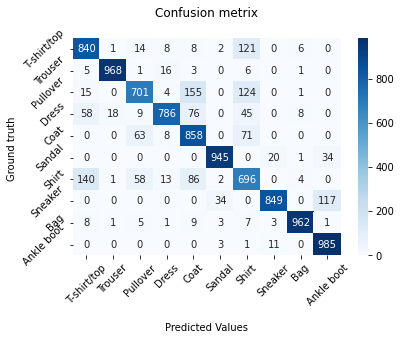

######################################################################
Test accuracy per class:
Test accuracy for class number 0 is:
 0.8399999737739563
Test accuracy for class number 1 is:
 0.9679999947547913
Test accuracy for class number 2 is:
 0.7009999752044678
Test accuracy for class number 3 is:
 0.7860000133514404
Test accuracy for class number 4 is:
 0.8579999804496765
Test accuracy for class number 5 is:
 0.9449999928474426
Test accuracy for class number 6 is:
 0.6959999799728394
Test accuracy for class number 7 is:
 0.8489999771118164
Test accuracy for class number 8 is:
 0.9620000123977661
Test accuracy for class number 9 is:
 0.9850000143051147


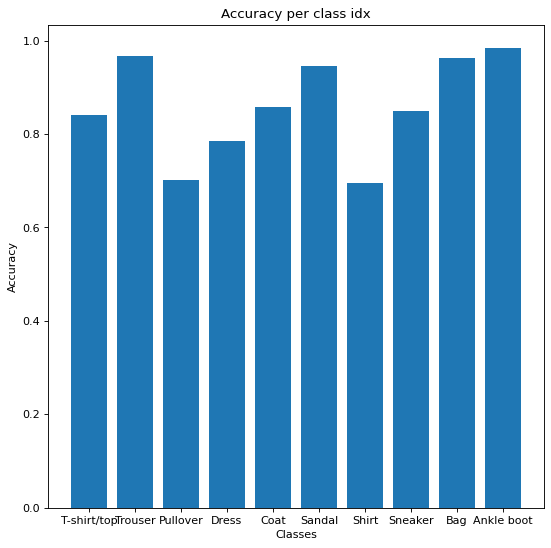

######################################################################
Model 2 :
Epoch 1/10
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5310 - accuracy: 0.8052 - val_loss: 0.3537 - val_accuracy: 0.8709
Epoch 2/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.3579 - accuracy: 0.8683 - val_loss: 0.3176 - val_accuracy: 0.8805
Epoch 3/10
1563/1563 [==============================] - 64s 41ms/step - loss: 0.3121 - accuracy: 0.8845 - val_loss: 0.2792 - val_accuracy: 0.8996
Epoch 4/10
1563/1563 [==============================] - 62s 40ms/step - loss: 0.2814 - accuracy: 0.8954 - val_loss: 0.2923 - val_accuracy: 0.8946
Epoch 5/10
1563/1563 [==============================] - 64s 41ms/step - loss: 0.2656 - accuracy: 0.9005 - val_loss: 0.2497 - val_accuracy: 0.9082
Epoch 6/10
1563/1563 [==============================] - 61s 39ms/step - loss: 0.2461 - accuracy: 0.9074 - val_loss: 0.2519 - val_accuracy: 0.9066
Epoch 7/10
1563/1563 [=====================

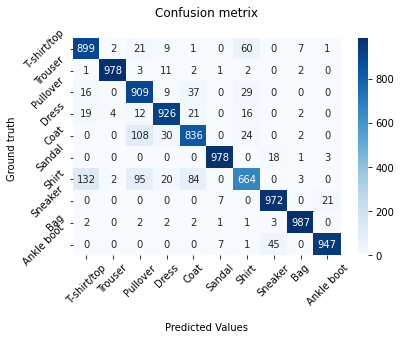

######################################################################
Test accuracy per class:
Test accuracy for class number 0 is:
 0.8989999890327454
Test accuracy for class number 1 is:
 0.9779999852180481
Test accuracy for class number 2 is:
 0.9089999794960022
Test accuracy for class number 3 is:
 0.9259999990463257
Test accuracy for class number 4 is:
 0.8360000252723694
Test accuracy for class number 5 is:
 0.9779999852180481
Test accuracy for class number 6 is:
 0.6639999747276306
Test accuracy for class number 7 is:
 0.972000002861023
Test accuracy for class number 8 is:
 0.9869999885559082
Test accuracy for class number 9 is:
 0.9470000267028809


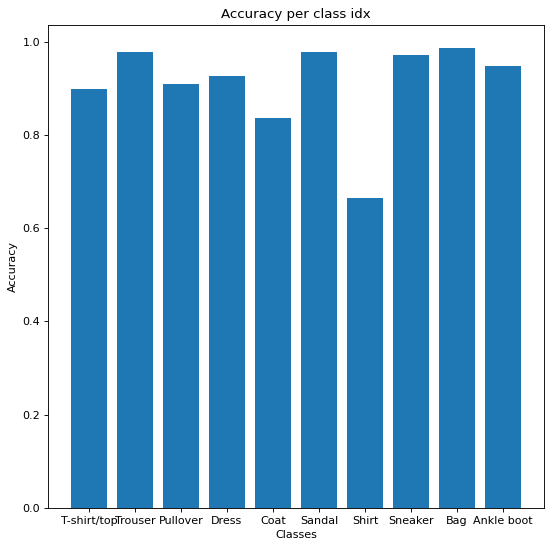

######################################################################
Model 3 :
Epoch 1/10
1563/1563 [==============================] - 86s 55ms/step - loss: 0.4689 - accuracy: 0.8299 - val_loss: 0.3364 - val_accuracy: 0.8763
Epoch 2/10
1563/1563 [==============================] - 83s 53ms/step - loss: 0.3367 - accuracy: 0.8755 - val_loss: 0.3307 - val_accuracy: 0.8785
Epoch 3/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.2953 - accuracy: 0.8907 - val_loss: 0.2834 - val_accuracy: 0.8947
Epoch 4/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.2743 - accuracy: 0.8972 - val_loss: 0.2599 - val_accuracy: 0.9020
Epoch 5/10
1563/1563 [==============================] - 85s 54ms/step - loss: 0.2527 - accuracy: 0.9067 - val_loss: 0.2501 - val_accuracy: 0.9064
Epoch 6/10
1563/1563 [==============================] - 86s 55ms/step - loss: 0.2378 - accuracy: 0.9107 - val_loss: 0.2387 - val_accuracy: 0.9120
Epoch 7/10
1563/1563 [=====================

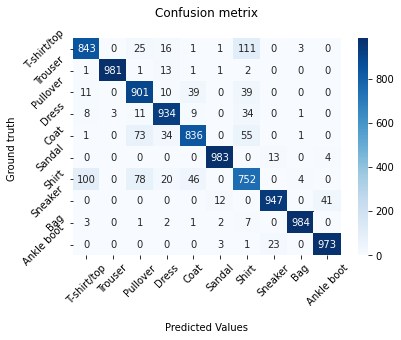

######################################################################
Test accuracy per class:
Test accuracy for class number 0 is:
 0.8429999947547913
Test accuracy for class number 1 is:
 0.9810000061988831
Test accuracy for class number 2 is:
 0.9010000228881836
Test accuracy for class number 3 is:
 0.9340000152587891
Test accuracy for class number 4 is:
 0.8360000252723694
Test accuracy for class number 5 is:
 0.9829999804496765
Test accuracy for class number 6 is:
 0.7519999742507935
Test accuracy for class number 7 is:
 0.9470000267028809
Test accuracy for class number 8 is:
 0.984000027179718
Test accuracy for class number 9 is:
 0.9729999899864197


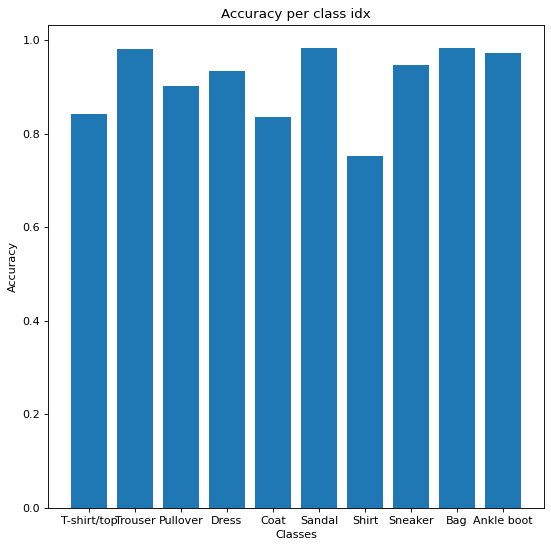

######################################################################
Model 4 :
Epoch 1/10
1563/1563 [==============================] - 89s 57ms/step - loss: 0.5970 - accuracy: 0.7873 - val_loss: 0.3475 - val_accuracy: 0.8688
Epoch 2/10
1563/1563 [==============================] - 87s 56ms/step - loss: 0.4070 - accuracy: 0.8532 - val_loss: 0.3173 - val_accuracy: 0.8837
Epoch 3/10
1563/1563 [==============================] - 89s 57ms/step - loss: 0.3625 - accuracy: 0.8684 - val_loss: 0.2830 - val_accuracy: 0.8971
Epoch 4/10
1563/1563 [==============================] - 88s 57ms/step - loss: 0.3314 - accuracy: 0.8818 - val_loss: 0.3034 - val_accuracy: 0.8834
Epoch 5/10
1563/1563 [==============================] - 89s 57ms/step - loss: 0.3093 - accuracy: 0.8870 - val_loss: 0.2653 - val_accuracy: 0.9011
Epoch 6/10
1563/1563 [==============================] - 88s 57ms/step - loss: 0.2946 - accuracy: 0.8923 - val_loss: 0.2916 - val_accuracy: 0.8903
Epoch 7/10
1563/1563 [=====================

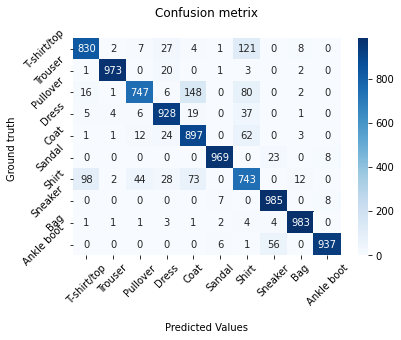

######################################################################
Test accuracy per class:
Test accuracy for class number 0 is:
 0.8299999833106995
Test accuracy for class number 1 is:
 0.9729999899864197
Test accuracy for class number 2 is:
 0.746999979019165
Test accuracy for class number 3 is:
 0.9279999732971191
Test accuracy for class number 4 is:
 0.8970000147819519
Test accuracy for class number 5 is:
 0.968999981880188
Test accuracy for class number 6 is:
 0.7429999709129333
Test accuracy for class number 7 is:
 0.9850000143051147
Test accuracy for class number 8 is:
 0.9829999804496765
Test accuracy for class number 9 is:
 0.9369999766349792


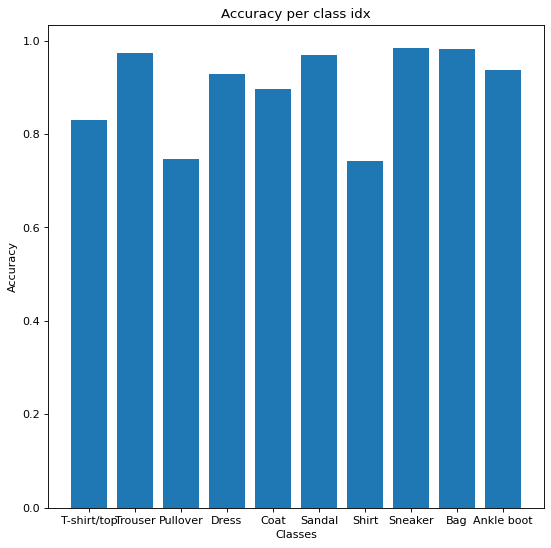

######################################################################
Model 5 :
Epoch 1/10
1563/1563 [==============================] - 90s 57ms/step - loss: 0.6246 - accuracy: 0.7883 - val_loss: 0.4023 - val_accuracy: 0.8601
Epoch 2/10
1563/1563 [==============================] - 90s 58ms/step - loss: 0.4377 - accuracy: 0.8548 - val_loss: 0.3381 - val_accuracy: 0.8912
Epoch 3/10
1563/1563 [==============================] - 88s 56ms/step - loss: 0.3963 - accuracy: 0.8708 - val_loss: 0.3506 - val_accuracy: 0.8862
Epoch 4/10
1563/1563 [==============================] - 90s 57ms/step - loss: 0.3696 - accuracy: 0.8809 - val_loss: 0.3556 - val_accuracy: 0.8816
Epoch 5/10
1563/1563 [==============================] - 90s 57ms/step - loss: 0.3563 - accuracy: 0.8876 - val_loss: 0.3088 - val_accuracy: 0.9036
Epoch 6/10
1563/1563 [==============================] - 88s 56ms/step - loss: 0.3476 - accuracy: 0.8927 - val_loss: 0.3116 - val_accuracy: 0.9047
Epoch 7/10
1563/1563 [=====================

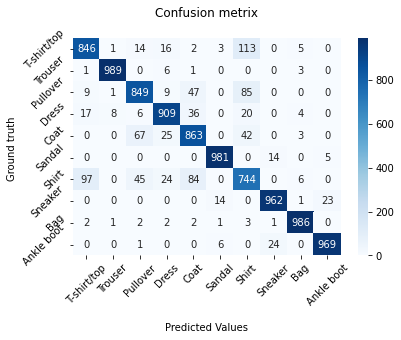

######################################################################
Test accuracy per class:
Test accuracy for class number 0 is:
 0.8460000157356262
Test accuracy for class number 1 is:
 0.9890000224113464
Test accuracy for class number 2 is:
 0.8489999771118164
Test accuracy for class number 3 is:
 0.9089999794960022
Test accuracy for class number 4 is:
 0.8629999756813049
Test accuracy for class number 5 is:
 0.9810000061988831
Test accuracy for class number 6 is:
 0.7440000176429749
Test accuracy for class number 7 is:
 0.9620000123977661
Test accuracy for class number 8 is:
 0.9860000014305115
Test accuracy for class number 9 is:
 0.968999981880188


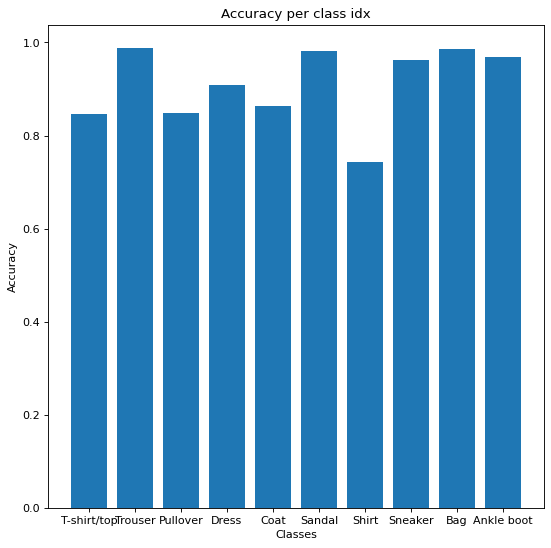

######################################################################
Model 6 :
Epoch 1/10
1563/1563 [==============================] - 92s 59ms/step - loss: 1.0170 - accuracy: 0.7854 - val_loss: 0.7345 - val_accuracy: 0.8485
Epoch 2/10
1563/1563 [==============================] - 90s 58ms/step - loss: 0.6831 - accuracy: 0.8469 - val_loss: 0.6326 - val_accuracy: 0.8542
Epoch 3/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.6074 - accuracy: 0.8629 - val_loss: 0.5192 - val_accuracy: 0.8874
Epoch 4/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.5711 - accuracy: 0.8708 - val_loss: 0.5240 - val_accuracy: 0.8802
Epoch 5/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.5462 - accuracy: 0.8767 - val_loss: 0.4854 - val_accuracy: 0.8966
Epoch 6/10
1563/1563 [==============================] - 91s 58ms/step - loss: 0.5323 - accuracy: 0.8790 - val_loss: 0.5272 - val_accuracy: 0.8790
Epoch 7/10
1563/1563 [=====================

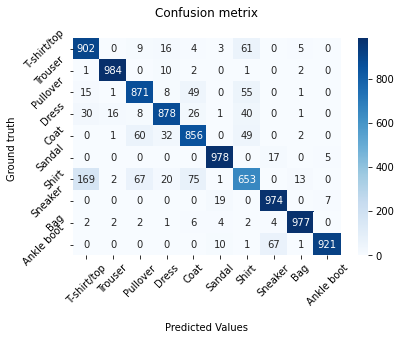

######################################################################
Test accuracy per class:
Test accuracy for class number 0 is:
 0.9020000100135803
Test accuracy for class number 1 is:
 0.984000027179718
Test accuracy for class number 2 is:
 0.8709999918937683
Test accuracy for class number 3 is:
 0.878000020980835
Test accuracy for class number 4 is:
 0.8560000061988831
Test accuracy for class number 5 is:
 0.9779999852180481
Test accuracy for class number 6 is:
 0.652999997138977
Test accuracy for class number 7 is:
 0.9739999771118164
Test accuracy for class number 8 is:
 0.9769999980926514
Test accuracy for class number 9 is:
 0.9210000038146973


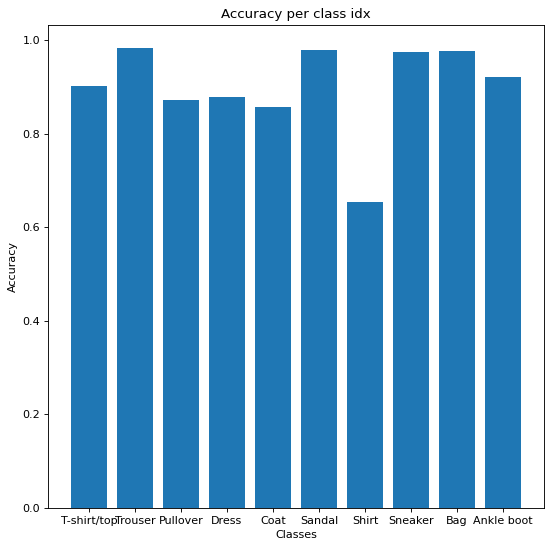

######################################################################


In [ ]:
transforms=[cutout] # 'random_crop', 'cutout', 'add_noise'
TrainModels(models, transforms, epochs=10, horizontal_flip=True, rotation_range=5)

Acuuracy VS Epoch and Loss VS Epoch for both training and validation sets for all 6 models defined above. (The name of the graph that belongs to the $i$'th model is starting with $i$/20220418/...)

In [ ]:
%tensorboard --logdir logs/fit/Models

## Results Summary

In [ ]:
d = pd.DataFrame.from_dict({
     'Model': ['Baseline', 'Baseline+Aug', 'Aug +Conv2D +baseline', 'Aug +Conv2D +baseline + BN', 'Aug +Conv2D +baseline + BN+Dropout',
               'Aug +Conv2D +baseline + BN+ Dropout+ L2_reg', 'Aug +Conv2D +baseline + BN+ Dropout+ L1_reg'],
     'Training Accuracy': ['0.9101', '0.8773', '0.9238', '0.9247', '0.9076', '0.9043', '0.8868'],
     'Validation Accuracy': ['0.8882', '0.8668', '0.9168', '0.9223', '0.9051', '0.9161', '0.9026'],
     'Test Accuracy': ['0.8852', '0.859', '0.9096', '0.9133', '0.8992', '0.9097', '0.8993']
     })
d

,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,Baseline,0.9101,0.8882,0.8852
1,Baseline+Aug,0.8773,0.8668,0.859
2,Aug +Conv2D +baseline,0.9238,0.9168,0.9096
3,Aug +Conv2D +baseline + BN,0.9247,0.9223,0.9133
4,Aug +Conv2D +baseline + BN+Dropout,0.9076,0.9051,0.8992
5,Aug +Conv2D +baseline + BN+ Dropout+ L2_reg,0.9043,0.9161,0.9097
6,Aug +Conv2D +baseline + BN+ Dropout+ L1_reg,0.8868,0.9026,0.8993


## Best model results
The best model is model3, which is a CNN model with Batch Normalization without any regularization methods.

The train accuracy is 0.9247, The validation accuracy is 0.9223, The test accuracy is 0.9133.

1.	The results show that data augmentations were not helpful in the baseline model, and cause performance degradation. We suspect that because the dataset is quite simple in terms of possible variations, the augmentations added noise more than additional information.

2.	The most significant improvement has been achieved by adding the conv2D layers.
Adding a Conv2d layer to use the spatial features in the images (“model 2”) - before flattening the 2D input and applying the dense layers, there is a Conv2d layer with 32 kernels of 3*3 with ‘same’ padding (to maintain the same dimensions as the input image) and a “Relu” activation. These kernels are convolved with the input image to produce 32 different representation maps of the input. This layer improves the accuracies significantly.
3.	Using regularization layers – a Dropout layer was added to the Conv2D layer (“model 4”) - the Dropout layer helps prevent overfitting by randomly setting input units to 0. We can see in our observations that after we added the Dropout layer, the models are less suffer from overfitting, compared to model 3 or lower.
We got the best results with model 3, which includes conv2D, and batch normalization, which is a normalization step that fixes the means and variances of each layer's inputs.

4. 	Another interesting phenomenon is that the training accuracy is sometimes lower than the validation accuracy. The reason is that we are applying augmentations in an online fashion over the training set, therefore it is harder to predict samples from this set.

5. We also observed that regularization methods cause lower performance compared with the model without regularization. The reason is that we are using online augmentations which provide a kind of regularization, therefore using additional regularization methods is not needed.

### Training TSNE

In [ ]:
generate_tsne(model3, train_images, train_labels, 'embedding_logs_train_model3')

TSNE visualization for train images with best model

In [ ]:
%tensorboard --logdir=embedding_logs_train_model3
#If you cant see the visualization, click the refresh button

### Test set TSNE

In [ ]:
generate_tsne(model3, test_images, test_labels, 'embedding_logs_test_model3')

TSNE visualization for test images with best model

In [ ]:
%tensorboard --logdir=embedding_logs_test_model3 
#If you cant see the visualization, click the refresh button

We can see that the latent representation of each class is well seperated

Exporting the code to PDF

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/Colab\ Notebooks/main.ipynb ./

In [ ]:
!jupyter nbconvert --to PDF "main.ipynb"

[NbConvertApp] Converting notebook main.ipynb to PDF
[NbConvertApp] ERROR | Notebook JSON is invalid: data must be valid exactly by one of oneOf definition

Failed validating <unset> in notebook:

On instance:
<unset>
[NbConvertApp] Support files will be in main_files/
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvert